<h1> Introduction/Business Problem

Without a doubt, gun violence in the US has become a huge problem in the past couple decades, effecting hundreds of thousands nationwide.  This project is seeking to explore the areas affected within the last year (2019) and determining which areas tend to be more at risk.

I am going to use the FourSquare API to search the top venues around each area the cluster them into groups to see how many end up in each cluster.  Then I'll additionally overlay that data with per capita income rates of each state/county in the country.

<h1> Data

1. The Gun Violence Archive contains public datasets containing the metadata of each mass shooting for every year, including location, time, and number of casualities.  
    1. https://www.gunviolencearchive.org/reports/mass-shooting
    
    
2. Wikipedia has a list of the per capita incomes by state and county for all states (mostly seperate for counties), and I will aggregate this data to make a choropleth map underlaying the clusters of shootings in recent months.
    1. by state: https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_income#States_and_territories_ranked_by_per_capita_income
    
    2. by county:  https://en.wikipedia.org/wiki/List_of_United_States_counties_by_per_capita_income
    
    3. by city: https://en.wikipedia.org/wiki/List_of_United_States_metropolitan_areas_by_per_capita_income 

# Methodology

1. put in incomes
2. create clusters by per capita income in city/county
3. create another set of clusters by the venues of each city/county using foursquare api
4. for both above **use the number of injured/killed as a measurement**
    3. ex. i am going to assume if the number killed is higher, that region is more 'at risk'
4. compare the clusters for similarities in them

In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.cluster import KMeans

### Cleaning the 2019 Shootings data

In [2]:
df = pd.read_csv('2019_Shootings.csv')
df

Incident Date           State City Or County  \
0    December 29, 2019        Illinois       Danville   
1    December 29, 2019        New York        Buffalo   
2    December 29, 2019      California          Ceres   
3    December 27, 2019      California        Modesto   
4    December 27, 2019         Georgia       Kennesaw   
..                 ...             ...            ...   
412    January 4, 2019      California       Torrance   
413    January 3, 2019         Arizona           Yuma   
414    January 2, 2019        Arkansas      Jonesboro   
415    January 1, 2019  South Carolina       Columbia   
416    January 1, 2019         Florida    Tallahassee   

                            Address  # Killed  # Injured  Operations  
0        1803 block of Westview Ave         0          5         NaN  
1         50 block of Henrietta Ave         1          3         NaN  
2         800 block of Allacante Dr         0          5         NaN  
3          1900 block of Vernon Ave         1          3         NaN  
4             1575 Ridenour Pkwy NW         0          4         NaN  
..                              ...       ...        ...         ...  
412            22501 Hawthorne Blvd         3          4         NaN  
413  3800 block of E. County 18½ St         1          3         NaN  
414                  3516 Galaxy St         1          3         NaN  
415                1709 Decker Blvd         0          5         NaN  
416             2020 W Pensacola St         0          5         NaN  

[417 rows x 7 columns]

I'm going to drop the 'Operations' and 'Address' columns, because they aren't necessary for my analysis

In [3]:
df.drop(['Address', 'Operations'], axis=1, inplace=True)
df

Incident Date           State City Or County  # Killed  # Injured
0    December 29, 2019        Illinois       Danville         0          5
1    December 29, 2019        New York        Buffalo         1          3
2    December 29, 2019      California          Ceres         0          5
3    December 27, 2019      California        Modesto         1          3
4    December 27, 2019         Georgia       Kennesaw         0          4
..                 ...             ...            ...       ...        ...
412    January 4, 2019      California       Torrance         3          4
413    January 3, 2019         Arizona           Yuma         1          3
414    January 2, 2019        Arkansas      Jonesboro         1          3
415    January 1, 2019  South Carolina       Columbia         0          5
416    January 1, 2019         Florida    Tallahassee         0          5

[417 rows x 5 columns]

There are no null values, which is desirable

In [4]:
df.isnull().sum()

Incident Date     0
State             0
City Or County    0
# Killed          0
# Injured         0
dtype: int64

### Add the per capita incomes of the county/city for each incident

I attempted to scrape various wiki pages to get the csv of incomes by county and city, but they weren't exhaustive of all possibilities.  So I created a new csv by hand to use instead.  This csv file contains per capita incomes ranging from 2014-2018, thus may not be the most stable information that accounts for fluctuations across years but I will go ahead with the analysis regardless.

In [5]:
per_capita = pd.read_csv('per_capita.csv')
per_capita

State                City Or County  Per capita income
0    Illinois                      Danville            16476.0
1    Illinois                       Chicago            36010.0
2    Illinois                        Aurora            28483.0
3    Illinois  Round Lake (Round Lake Park)            21585.0
4    Illinois                      Rockford            28732.0
..        ...                           ...                ...
223  Kentucky                 Elizabethtown            28022.0
224  Kentucky                     Owensboro            28410.0
225    Oregon                      Portland            36303.0
226  Nebraska                         Omaha            33276.0
227  Delaware                    Wilmington            27062.0

[228 rows x 3 columns]

There is one 'city' that I couldn't find the per capita income for because it is an 'unincorporated town' with a population of 500, so I will drop that row from the table because it doesns't benefit my analysis
(Cascilla Mississippi)

In [6]:
per_capita = per_capita.dropna()
df = df[df['City Or County'] != 'Cascilla']
per_capita.isnull().sum()
per_capita

State                City Or County  Per capita income
0    Illinois                      Danville            16476.0
1    Illinois                       Chicago            36010.0
2    Illinois                        Aurora            28483.0
3    Illinois  Round Lake (Round Lake Park)            21585.0
4    Illinois                      Rockford            28732.0
..        ...                           ...                ...
223  Kentucky                 Elizabethtown            28022.0
224  Kentucky                     Owensboro            28410.0
225    Oregon                      Portland            36303.0
226  Nebraska                         Omaha            33276.0
227  Delaware                    Wilmington            27062.0

[227 rows x 3 columns]

Now it's time to add the per capita incomes into the shootings csv

In [7]:
df = pd.merge(df, per_capita, on=['City Or County', 'State'], how='left')
df['# Incidences'] = 1
df

Incident Date           State City Or County  # Killed  # Injured  \
0    December 29, 2019        Illinois       Danville         0          5   
1    December 29, 2019        New York        Buffalo         1          3   
2    December 29, 2019      California          Ceres         0          5   
3    December 27, 2019      California        Modesto         1          3   
4    December 27, 2019         Georgia       Kennesaw         0          4   
..                 ...             ...            ...       ...        ...   
411    January 4, 2019      California       Torrance         3          4   
412    January 3, 2019         Arizona           Yuma         1          3   
413    January 2, 2019        Arkansas      Jonesboro         1          3   
414    January 1, 2019  South Carolina       Columbia         0          5   
415    January 1, 2019         Florida    Tallahassee         0          5   

     Per capita income  # Incidences  
0              16476.0             1  
1              31542.0             1  
2              18575.0             1  
3              23034.0             1  
4              31177.0             1  
..                 ...           ...  
411            36876.0             1  
412            21665.0             1  
413            26049.0             1  
414            28649.0             1  
415            25471.0             1  

[416 rows x 7 columns]

In [8]:
df.isnull().sum()

Incident Date        0
State                0
City Or County       0
# Killed             0
# Injured            0
Per capita income    0
# Incidences         0
dtype: int64

In [9]:
# get rid of parentheses in some cities
for i, row in df.iterrows():
    toreplace = row['City Or County']
    if '(' in row['City Or County']:
        places = row['City Or County'].split('(')
        toreplace = places[0]
    
    df.at[i,'City Or County'] = toreplace

In [10]:
df = df.groupby(['City Or County', 'State']).sum().reset_index()
df['Address'] = df['City Or County'] + ', ' + df['State']
df['Per capita income'] = df['Per capita income'] / df['# Incidences']
df['kills/incidence'] = df['# Killed'] / df['# Incidences']
df.drop('State', inplace=True, axis=1)
df

City Or County  # Killed  # Injured  Per capita income  # Incidences  \
0         Abbeville         3          1            21185.0             1   
1          Abington         5          0            23380.0             1   
2             Akron         1          7            31774.0             2   
3            Albany         0          4            18887.0             1   
4       Albuquerque         5          9            26876.0             3   
..              ...       ...        ...                ...           ...   
222      Wilmington         2          2            16282.0             1   
223      Wilmington         0         10            27062.0             2   
224  Winston Salem          2         11            26668.0             2   
225         Yucaipa         0          5            26103.0             1   
226            Yuma         1          3            21665.0             1   

                            Address  kills/incidence  
0         Abbeville, South Carolina         3.000000  
1           Abington, Massachusetts         5.000000  
2                       Akron, Ohio         0.500000  
3                   Albany, Georgia         0.000000  
4           Albuquerque, New Mexico         1.666667  
..                              ...              ...  
222          Wilmington, California         2.000000  
223            Wilmington, Delaware         0.000000  
224  Winston Salem , North Carolina         1.000000  
225             Yucaipa, California         0.000000  
226                   Yuma, Arizona         1.000000  

[227 rows x 7 columns]

In [11]:
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [12]:
# credit to https://towardsdatascience.com/geocode-with-python-161ec1e62b89 for this snippet of code

locator = Nominatim(user_agent='myGeocoder')
geocode = RateLimiter(locator.geocode, min_delay_seconds=.1)
# 2- - create location column
df['location'] = df['Address'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)

RateLimiter caught an error, retrying (0/2 tries). Called with (*('Ivanhoe, California',), **{}).
Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/urllib/request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "//anaconda3/lib/python3.7/http/client.py", line 1229, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1275, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1224, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1016, in _send_output
    self.send(msg)
  File "//anaconda3/lib/python3.7/http/client.py", line 956, in send
    self.connect()
  File "//anaconda3/lib/python3.7/http/client.py", line 1384, in connect
    super().connect()
  File "//anaconda3/lib/python3.7/ht

In [13]:
df.drop(['point', 'altitude'], axis=1, inplace=True)
df

City Or County  # Killed  # Injured  Per capita income  # Incidences  \
0         Abbeville         3          1            21185.0             1   
1          Abington         5          0            23380.0             1   
2             Akron         1          7            31774.0             2   
3            Albany         0          4            18887.0             1   
4       Albuquerque         5          9            26876.0             3   
..              ...       ...        ...                ...           ...   
222      Wilmington         2          2            16282.0             1   
223      Wilmington         0         10            27062.0             2   
224  Winston Salem          2         11            26668.0             2   
225         Yucaipa         0          5            26103.0             1   
226            Yuma         1          3            21665.0             1   

                            Address  kills/incidence  \
0         Abbeville, South Carolina         3.000000   
1           Abington, Massachusetts         5.000000   
2                       Akron, Ohio         0.500000   
3                   Albany, Georgia         0.000000   
4           Albuquerque, New Mexico         1.666667   
..                              ...              ...   
222          Wilmington, California         2.000000   
223            Wilmington, Delaware         0.000000   
224  Winston Salem , North Carolina         1.000000   
225             Yucaipa, California         0.000000   
226                   Yuma, Arizona         1.000000   

                                              location   latitude   longitude  
0    (Abbeville County, South Carolina, United Stat...  34.226495  -82.436404  
1    (Abington, Plymouth County, Massachusetts, Uni...  42.104823  -70.945322  
2    (Akron, Summit County, Ohio, United States of ...  41.083064  -81.518485  
3    (Albany, Dougherty County, Georgia, United Sta...  31.578206  -84.155681  
4    (Albuquerque, Bernalillo County, New Mexico, U...  35.084103 -106.650985  
..                                                 ...        ...         ...  
222  (Wilmington, Los Angeles, Los Angeles County, ...  33.780018 -118.262571  
223  (Wilmington, New Castle County, Delaware, Unit...  39.745947  -75.546589  
224  (Winston-Salem, Forsyth County, North Carolina...  36.099813  -80.244052  
225  (Yucaipa, San Bernardino County, California, 9...  34.033625 -117.043087  
226  (Yuma, Yuma County, Arizona, 85364, United Sta...  32.692659 -114.627616  

[227 rows x 10 columns]

Map the initial USA map with folium

In [14]:
USA_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

for address, lat, lng, num in zip(df['Address'], df['latitude'], df['longitude'], df['# Incidences']):
    label = folium.Popup(address, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=num*2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff8666',
        fill_opacity=0.7,
        parse_html=False).add_to(USA_map)

USA_map

This shows us the cities with the most incidences within 2019, where Chicago is clearly in the lead.  Now let's look at how many killings there are per incidence in the US:

In [15]:
USA_map2 = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

for address, lat, lng, num in zip(df['Address'], df['latitude'], df['longitude'], df['kills/incidence']):
    label = folium.Popup(address, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=num*2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff8666',
        fill_opacity=0.7,
        parse_html=False).add_to(USA_map2)

USA_map2

From this we can see that the distribution has significantly shifted, with Virginia Beach and El Paso taking the lead.

### Now, create a first set of "clusters" using quartiles of the per capita values

Cluster 1 will be the first quartile,

Cluster 2 will be the second,

Cluster 3 will be the third,

Cluster 4 will be the fourth, and

Cluster 5 the outliers to the right

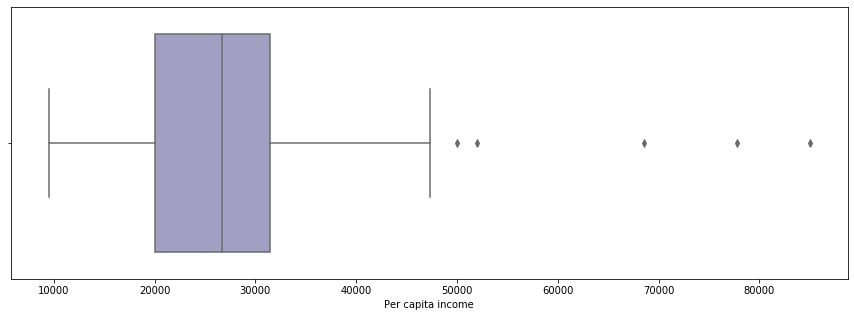

In [16]:
ax = plt.figure(figsize=(15,5))
ax = sns.boxplot(x=df['Per capita income'], orient='h', palette='Purples')

In [17]:
df['Per capita income'].describe()

count      227.000000
mean     26820.356828
std       9950.645040
min       9507.000000
25%      20040.500000
50%      26668.000000
75%      31465.000000
max      84985.000000
Name: Per capita income, dtype: float64

In [18]:
firstq = df['Per capita income'].describe()['25%']
med = df['Per capita income'].describe()['50%']
thirdq = df['Per capita income'].describe()['75%']
boxmax = 47285.0  # boxplot's max, taken from the sorted per capita values
high = df['Per capita income'].describe()['max']
print(firstq, med, thirdq, boxmax, high)

20040.5 26668.0 31465.0 47285.0 84985.0


In [19]:
for i, row in df.iterrows():
    cluster = 0
    
    if row['Per capita income'] < firstq:
        cluster = 1
    elif row['Per capita income'] < med:
        cluster = 2
    elif row['Per capita income'] < thirdq:
        cluster = 3
    elif row['Per capita income'] < boxmax:
        cluster = 4
    else:
        cluster = 5
    
    df.at[i, 'PerC_Cluster'] = cluster
df = df.astype({'PerC_Cluster':'int32'})
df

City Or County  # Killed  # Injured  Per capita income  # Incidences  \
0         Abbeville         3          1            21185.0             1   
1          Abington         5          0            23380.0             1   
2             Akron         1          7            31774.0             2   
3            Albany         0          4            18887.0             1   
4       Albuquerque         5          9            26876.0             3   
..              ...       ...        ...                ...           ...   
222      Wilmington         2          2            16282.0             1   
223      Wilmington         0         10            27062.0             2   
224  Winston Salem          2         11            26668.0             2   
225         Yucaipa         0          5            26103.0             1   
226            Yuma         1          3            21665.0             1   

                            Address  kills/incidence  \
0         Abbeville, South Carolina         3.000000   
1           Abington, Massachusetts         5.000000   
2                       Akron, Ohio         0.500000   
3                   Albany, Georgia         0.000000   
4           Albuquerque, New Mexico         1.666667   
..                              ...              ...   
222          Wilmington, California         2.000000   
223            Wilmington, Delaware         0.000000   
224  Winston Salem , North Carolina         1.000000   
225             Yucaipa, California         0.000000   
226                   Yuma, Arizona         1.000000   

                                              location   latitude   longitude  \
0    (Abbeville County, South Carolina, United Stat...  34.226495  -82.436404   
1    (Abington, Plymouth County, Massachusetts, Uni...  42.104823  -70.945322   
2    (Akron, Summit County, Ohio, United States of ...  41.083064  -81.518485   
3    (Albany, Dougherty County, Georgia, United Sta...  31.578206  -84.155681   
4    (Albuquerque, Bernalillo County, New Mexico, U...  35.084103 -106.650985   
..                                                 ...        ...         ...   
222  (Wilmington, Los Angeles, Los Angeles County, ...  33.780018 -118.262571   
223  (Wilmington, New Castle County, Delaware, Unit...  39.745947  -75.546589   
224  (Winston-Salem, Forsyth County, North Carolina...  36.099813  -80.244052   
225  (Yucaipa, San Bernardino County, California, 9...  34.033625 -117.043087   
226  (Yuma, Yuma County, Arizona, 85364, United Sta...  32.692659 -114.627616   

     PerC_Cluster  
0               2  
1               2  
2               4  
3               1  
4               3  
..            ...  
222             1  
223             3  
224             3  
225             2  
226             2  

[227 rows x 11 columns]

Now I'm going to map these clusters first by the number of instances

In [20]:
PerCapitaCluster_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

colors=['red', 'blue', 'purple', 'yellow', 'green']
for address, lat, lng, num, cluster in zip(df.index, df['latitude'], df['longitude'], df['# Incidences'], df['PerC_Cluster']):
    label = folium.Popup(address, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=num*1.5,
        popup=label,
        color=colors[cluster-1],
        fill=True,
        fill_color=colors[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(PerCapitaCluster_map)

PerCapitaCluster_map

Now let's look at the distribution of those clusters instead in terms of killings per incidence

In [21]:
PerCapitaCluster_map2 = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

colors=['red', 'blue', 'purple', 'yellow', 'green']
for address, lat, lng, num, cluster in zip(df.index, df['latitude'], df['longitude'], df['kills/incidence'], df['PerC_Cluster']):
    label = folium.Popup(address, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=num*1.5,
        popup=label,
        color=colors[cluster-1],
        fill=True,
        fill_color=colors[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(PerCapitaCluster_map2)

PerCapitaCluster_map2

This third map shows the number killed for each per capita income cluster

In [22]:
PerCapitaCluster_map3 = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

colors=['red', 'blue', 'purple', 'yellow', 'green']
for address, lat, lng, num, cluster in zip(df.index, df['latitude'], df['longitude'], df['# Killed'], df['PerC_Cluster']):
    label = folium.Popup(address, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=num*1.5,
        popup=label,
        color=colors[cluster-1],
        fill=True,
        fill_color=colors[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(PerCapitaCluster_map3)

PerCapitaCluster_map3

From these maps, we can see that there is a pattern where the mere magnitude of incidences and killings is significantly higher in cities with lower per capita income (maps 1 and 3).  However, once we look at the killings per incidence, the distribution evens out slightly across each cluster (map 2).  

Therefore, it is clear that the number of incidences is higher in lower income cities, but that does not necessarily say anything about the violence of those instances.

In [31]:
#Foursquare client data
CLIENT_ID = ~
CLIENT_SECRET = ~
VERSION = ~

In [41]:
def get_city_venues(df):
    counter = 1
    venues = []
    for city, lat, lng in zip(df['Address'], df['latitude'], df['longitude']):
        print(city)
        
        #api request url
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}'.format(
                    CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, 20)
        #make get request
        results = requests.get(url).json()['response']['groups'][0]['items']
 
        venues.append([(
            city, lat, lng, v['venue']['name'], v['venue']['location']['lat'],
            v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])
        
    all_venues = pd.DataFrame([item for venue_list in venues for item in venue_list])
    all_venues.columns = ['Address', 'Address Lat', 'Address Lng',
                         'Venue', 'Venue Lat', 'Venue Lng', 'Venue Category']
    
    return all_venues

In [42]:
df_venues = get_city_venues(df)

Abbeville, South Carolina
Abington, Massachusetts
Akron, Ohio
Albany, Georgia
Albuquerque, New Mexico
Alexandria, Louisiana
Allendale, South Carolina
Allentown, Pennsylvania
Amarillo, Texas
Atlanta, Georgia
Atmore, Alabama
Augusta, Georgia
Aurora, Colorado
Aurora, Illinois
Austin, Texas
Baltimore, Maryland
Baton Rouge, Louisiana
Bay Shore, New York
Beaumont, Texas
Belle Glade, Florida
Birmingham, Alabama
Boston, Massachusetts
Bronx, New York
Brooklyn, New York
Brownsville, Florida
Buffalo, New York
Camden, New Jersey
Canoga Park, California
Carbondale, Illinois
Cedar Rapids, Iowa
Ceres, California
Charlotte, North Carolina
Chesapeake, Virginia
Cheyenne, Wyoming
Chicago, Illinois
Chippewa Falls, Wisconsin
Claflin, Kansas
Clairton, Pennsylvania
Cleveland, Ohio
Cleveland, Texas
Clinton, Mississippi
Columbia, South Carolina
Columbus, Georgia
Columbus, Ohio
Conyers, Georgia
Coralville, Iowa
Corpus Christi, Texas
Cotton Valley, Louisiana
Cottonport, Louisiana
Covington, Kentucky
Covington, T

In [43]:
df_venues.head()

Address  Address Lat  Address Lng  \
0  Abbeville, South Carolina    34.226495   -82.436404   
1  Abbeville, South Carolina    34.226495   -82.436404   
2  Abbeville, South Carolina    34.226495   -82.436404   
3  Abbeville, South Carolina    34.226495   -82.436404   
4  Abbeville, South Carolina    34.226495   -82.436404   

                        Venue  Venue Lat  Venue Lng           Venue Category  
0           The Village Grill  34.177727 -82.379931  New American Restaurant  
1       Main Street Coffee Co  34.176707 -82.377681              Coffee Shop  
2              Dollar General  34.174888 -82.377198           Discount Store  
3  Maria's Mexican Restaurant  34.177314 -82.379630       Mexican Restaurant  
4         fred's Super Dollar  34.168740 -82.410975           Discount Store

13 of the Cities returned less than 20 venues, and I'm going to drop those that are less than 15 venues (11 locations) because they are smaller cities/towns, and the low amount of venues returned will most likely skew the clusters created

In [49]:
pd.set_option('display.min_rows',20)
df_venues.groupby('Address').count()

Address Lat  Address Lng  Venue  Venue Lat  \
Address                                                                      
Abbeville, South Carolina                20           20     20         20   
Abington, Massachusetts                  20           20     20         20   
Akron, Ohio                              20           20     20         20   
Albany, Georgia                          20           20     20         20   
Albuquerque, New Mexico                  20           20     20         20   
Alexandria, Louisiana                    20           20     20         20   
Allendale, South Carolina                 6            6      6          6   
Allentown, Pennsylvania                  20           20     20         20   
Amarillo, Texas                          20           20     20         20   
Atlanta, Georgia                         20           20     20         20   
...                                     ...          ...    ...        ...   
West Chester, Ohio                       20           20     20         20   
West Covina, California                  20           20     20         20   
White Swan, Washington                    2            2      2          2   
Whiteville, North Carolina               20           20     20         20   
Wichita, Kansas                          20           20     20         20   
Wilmington, California                   20           20     20         20   
Wilmington, Delaware                     20           20     20         20   
Winston Salem , North Carolina           20           20     20         20   
Yucaipa, California                      20           20     20         20   
Yuma, Arizona                            20           20     20         20   

                                Venue Lng  Venue Category  
Address                                                    
Abbeville, South Carolina              20              20  
Abington, Massachusetts                20              20  
Akron, Ohio                            20              20  
Albany, Georgia                        20              20  
Albuquerque, New Mexico                20              20  
Alexandria, Louisiana                  20              20  
Allendale, South Carolina               6               6  
Allentown, Pennsylvania                20              20  
Amarillo, Texas                        20              20  
Atlanta, Georgia                       20              20  
...                                   ...             ...  
West Chester, Ohio                     20              20  
West Covina, California                20              20  
White Swan, Washington                  2               2  
Whiteville, North Carolina             20              20  
Wichita, Kansas                        20              20  
Wilmington, California                 20              20  
Wilmington, Delaware                   20              20  
Winston Salem , North Carolina         20              20  
Yucaipa, California                    20              20  
Yuma, Arizona                          20              20  

[227 rows x 6 columns]

In [50]:
addresses_todrop = ['White Swan, Washington', 'Hermanville, Mississippi', 'Cottonport, Louisiana', 'Claflin, Kansas', 
                   'Rochelle, Georgia', 'Cotton Valley, Louisiana', 'Allendale, South Carolina', 'Hensley, Arkansas',
                   'Elkmont, Alabama', 'Tallulah, Louisiana', 'Henning, Tennessee']
df_venues = df_venues[~df_venues['Address'].isin(addresses_todrop)]
df_venues

Address  Address Lat  Address Lng  \
0     Abbeville, South Carolina    34.226495   -82.436404   
1     Abbeville, South Carolina    34.226495   -82.436404   
2     Abbeville, South Carolina    34.226495   -82.436404   
3     Abbeville, South Carolina    34.226495   -82.436404   
4     Abbeville, South Carolina    34.226495   -82.436404   
5     Abbeville, South Carolina    34.226495   -82.436404   
6     Abbeville, South Carolina    34.226495   -82.436404   
7     Abbeville, South Carolina    34.226495   -82.436404   
8     Abbeville, South Carolina    34.226495   -82.436404   
9     Abbeville, South Carolina    34.226495   -82.436404   
...                         ...          ...          ...   
4375              Yuma, Arizona    32.692659  -114.627616   
4376              Yuma, Arizona    32.692659  -114.627616   
4377              Yuma, Arizona    32.692659  -114.627616   
4378              Yuma, Arizona    32.692659  -114.627616   
4379              Yuma, Arizona    32.692659  -114.627616   
4380              Yuma, Arizona    32.692659  -114.627616   
4381              Yuma, Arizona    32.692659  -114.627616   
4382              Yuma, Arizona    32.692659  -114.627616   
4383              Yuma, Arizona    32.692659  -114.627616   
4384              Yuma, Arizona    32.692659  -114.627616   

                                 Venue  Venue Lat   Venue Lng  \
0                    The Village Grill  34.177727  -82.379931   
1                Main Street Coffee Co  34.176707  -82.377681   
2                       Dollar General  34.174888  -82.377198   
3           Maria's Mexican Restaurant  34.177314  -82.379630   
4                  fred's Super Dollar  34.168740  -82.410975   
5                               Subway  34.173162  -82.376825   
6                        Family Dollar  34.187397  -82.400478   
7                                Bi-Lo  34.162851  -82.381501   
8                             7-Eleven  34.173285  -82.373050   
9                            Pizza Hut  34.162458  -82.382990   
...                                ...        ...         ...   
4375                   Texas Roadhouse  32.699891 -114.613179   
4376                          Squeezed  32.683731 -114.631807   
4377                     Stans Grocery  32.692563 -114.620390   
4378                     Smart & Final  32.698946 -114.618354   
4379                         Starbucks  32.672011 -114.623844   
4380          The Crossing Grill & Bar  32.678710 -114.625400   
4381                   In-N-Out Burger  32.698994 -114.600550   
4382  Cracker Barrel Old Country Store  32.695363 -114.603800   
4383                            Kohl's  32.702530 -114.607410   
4384                        Chase Bank  32.698923 -114.622117   

               Venue Category  
0     New American Restaurant  
1                 Coffee Shop  
2              Discount Store  
3          Mexican Restaurant  
4              Discount Store  
5              Sandwich Place  
6              Discount Store  
7               Grocery Store  
8           Convenience Store  
9                 Pizza Place  
...                       ...  
4375               Steakhouse  
4376                Juice Bar  
4377       Mexican Restaurant  
4378            Grocery Store  
4379              Coffee Shop  
4380      American Restaurant  
4381     Fast Food Restaurant  
4382      American Restaurant  
4383         Department Store  
4384                     Bank  

[4316 rows x 7 columns]

To get clusters, I need to one hot encode each venue category

In [51]:
print('There are {} unique categories'.format(len(df_venues['Venue Category'].unique())))

There are 308 unique categories


In [54]:
def one_hot_encode(df):
    onehot = pd.get_dummies(df[['Venue Category']], prefix='', prefix_sep='')
    onehot['Address'] = df['Address']
    
    #move to first column
    fixed_cols = [onehot.columns[-1]] + list(onehot.columns[:-1])
    onehot = onehot[fixed_cols]
    
    return onehot.groupby('Address').mean().reset_index()

In [55]:
df_onehot = one_hot_encode(df_venues)
df_onehot.head()

Address  Accessories Store  Adult Boutique  \
0  Abbeville, South Carolina                0.0             0.0   
1    Abington, Massachusetts                0.0             0.0   
2                Akron, Ohio                0.0             0.0   
3            Albany, Georgia                0.0             0.0   
4    Albuquerque, New Mexico                0.0             0.0   

   African Restaurant  Airport  American Restaurant  Antique Shop  Aquarium  \
0                 0.0      0.0                 0.00           0.0      0.00   
1                 0.0      0.0                 0.10           0.0      0.00   
2                 0.0      0.0                 0.05           0.0      0.00   
3                 0.0      0.0                 0.10           0.0      0.05   
4                 0.0      0.0                 0.05           0.0      0.00   

   Arcade  Arepa Restaurant  ...  Waterfront  Whisky Bar  Wine Bar  Wine Shop  \
0     0.0               0.0  ...         0.0         0.0       0.0       0.00   
1     0.0               0.0  ...         0.0         0.0       0.0       0.00   
2     0.0               0.0  ...         0.0         0.0       0.0       0.00   
3     0.0               0.0  ...         0.0         0.0       0.0       0.05   
4     0.0               0.0  ...         0.0         0.0       0.0       0.00   

   Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
0     0.0          0.0            0.0          0.0  0.0          0.0  
1     0.0          0.0            0.0          0.0  0.0          0.0  
2     0.0          0.0            0.0          0.0  0.0          0.0  
3     0.0          0.0            0.0          0.0  0.0          0.0  
4     0.0          0.0            0.0          0.0  0.0          0.0  

[5 rows x 309 columns]

Let's view the top 10 venues for each Address

In [56]:
def top_ten(df, num):
    def return_most_common(row):
        row_cats = row.iloc[1:]
        row_cats = row_cats.sort_values(ascending=False)
        return row_cats.index.values[0:num]
    
    indicator = ['st', 'nd', 'rd']
    cols = ['Address']
    for ind in range(num):
        try:
            cols.append('{}{} Most Common Venue'.format(ind+1, indicator[ind]))
        except:
            cols.append('{}th Most Common Venue'.format(ind+1))
    
    #create new df with those columns
    sorted_df = pd.DataFrame(columns=cols)
    sorted_df['Address'] = df['Address']
    
    for i in range(df.shape[0]):
        sorted_df.iloc[i, 1:] = return_most_common(df.iloc[i, :])
    return sorted_df

In [57]:
df_top = top_ten(df_onehot, 10)
df_top.head()

Address 1st Most Common Venue 2nd Most Common Venue  \
0  Abbeville, South Carolina  Fast Food Restaurant        Discount Store   
1    Abington, Massachusetts           Coffee Shop        Ice Cream Shop   
2                Akron, Ohio           Music Venue    Italian Restaurant   
3            Albany, Georgia   American Restaurant            Donut Shop   
4    Albuquerque, New Mexico                   Bar                  Café   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0            Gas Station         Grocery Store           Pizza Place   
1    American Restaurant          Liquor Store                   Bar   
2  Performing Arts Venue         Deli / Bodega            Art Museum   
3              BBQ Joint                 Hotel            University   
4                  Hotel         Design Studio                 Plaza   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0    Mexican Restaurant   Fried Chicken Joint                   Gym   
1        Breakfast Spot               Dog Run                  Café   
2             Speakeasy     Food & Drink Shop              Boutique   
3                 Plaza            Playground           Coffee Shop   
4                 Diner           Pizza Place           Coffee Shop   

  9th Most Common Venue 10th Most Common Venue  
0           Coffee Shop         Sandwich Place  
1  Fast Food Restaurant             Donut Shop  
2                  Café       Baseball Stadium  
3        Sandwich Place                   Park  
4           Music Venue           Burger Joint

Let's create our clusters and add it to this dataframe! First I will use the elbow method to determine the optimal number of clusters to create

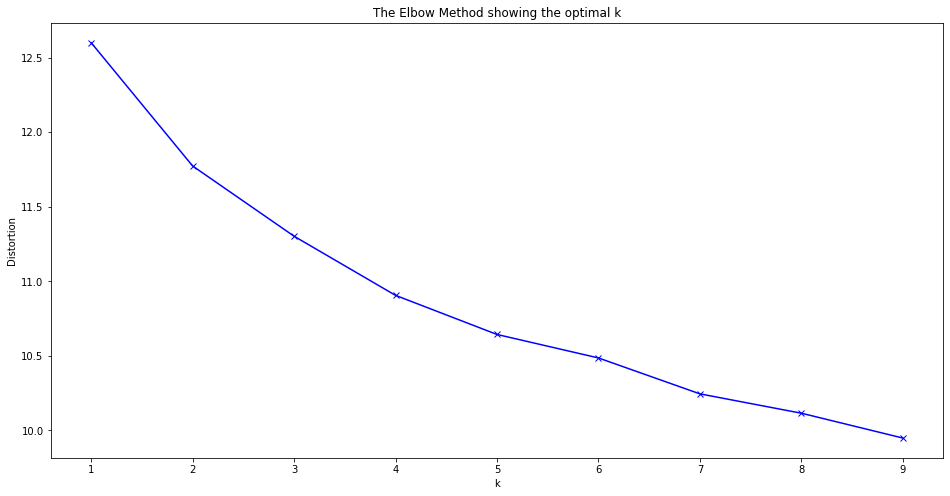

In [58]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_onehot.drop('Address', axis=1))
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow isn't especially clear, but I will choose 4 clusters for this dataset (tried 5, but some were similar)

In [59]:
def create_clusters(onehot, top_ten):
    kclusters=4
    cluster_df = onehot.drop('Address', axis=1)
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)
    
    #put clusters into top_five dataframe
    top_ten.insert(0, 'Cluster Labels', kmeans.labels_)  

In [60]:
create_clusters(df_onehot, df_top)

In [61]:
df_top.head()

Cluster Labels                    Address 1st Most Common Venue  \
0               1  Abbeville, South Carolina  Fast Food Restaurant   
1               0    Abington, Massachusetts           Coffee Shop   
2               0                Akron, Ohio           Music Venue   
3               0            Albany, Georgia   American Restaurant   
4               0    Albuquerque, New Mexico                   Bar   

  2nd Most Common Venue  3rd Most Common Venue 4th Most Common Venue  \
0        Discount Store            Gas Station         Grocery Store   
1        Ice Cream Shop    American Restaurant          Liquor Store   
2    Italian Restaurant  Performing Arts Venue         Deli / Bodega   
3            Donut Shop              BBQ Joint                 Hotel   
4                  Café                  Hotel         Design Studio   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0           Pizza Place    Mexican Restaurant   Fried Chicken Joint   
1                   Bar        Breakfast Spot               Dog Run   
2            Art Museum             Speakeasy     Food & Drink Shop   
3            University                 Plaza            Playground   
4                 Plaza                 Diner           Pizza Place   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                   Gym           Coffee Shop         Sandwich Place  
1                  Café  Fast Food Restaurant             Donut Shop  
2              Boutique                  Café       Baseball Stadium  
3           Coffee Shop        Sandwich Place                   Park  
4           Coffee Shop           Music Venue           Burger Joint

In [62]:
df = df_top.merge(df, on='Address')
df.set_index('Address', inplace=True)
df.head()

Cluster Labels 1st Most Common Venue  \
Address                                                           
Abbeville, South Carolina               1  Fast Food Restaurant   
Abington, Massachusetts                 0           Coffee Shop   
Akron, Ohio                             0           Music Venue   
Albany, Georgia                         0   American Restaurant   
Albuquerque, New Mexico                 0                   Bar   

                          2nd Most Common Venue  3rd Most Common Venue  \
Address                                                                  
Abbeville, South Carolina        Discount Store            Gas Station   
Abington, Massachusetts          Ice Cream Shop    American Restaurant   
Akron, Ohio                  Italian Restaurant  Performing Arts Venue   
Albany, Georgia                      Donut Shop              BBQ Joint   
Albuquerque, New Mexico                    Café                  Hotel   

                          4th Most Common Venue 5th Most Common Venue  \
Address                                                                 
Abbeville, South Carolina         Grocery Store           Pizza Place   
Abington, Massachusetts            Liquor Store                   Bar   
Akron, Ohio                       Deli / Bodega            Art Museum   
Albany, Georgia                           Hotel            University   
Albuquerque, New Mexico           Design Studio                 Plaza   

                          6th Most Common Venue 7th Most Common Venue  \
Address                                                                 
Abbeville, South Carolina    Mexican Restaurant   Fried Chicken Joint   
Abington, Massachusetts          Breakfast Spot               Dog Run   
Akron, Ohio                           Speakeasy     Food & Drink Shop   
Albany, Georgia                           Plaza            Playground   
Albuquerque, New Mexico                   Diner           Pizza Place   

                          8th Most Common Venue 9th Most Common Venue  ...  \
Address                                                                ...   
Abbeville, South Carolina                   Gym           Coffee Shop  ...   
Abington, Massachusetts                    Café  Fast Food Restaurant  ...   
Akron, Ohio                            Boutique                  Café  ...   
Albany, Georgia                     Coffee Shop        Sandwich Place  ...   
Albuquerque, New Mexico             Coffee Shop           Music Venue  ...   

                          City Or County # Killed  # Injured  \
Address                                                        
Abbeville, South Carolina      Abbeville        3          1   
Abington, Massachusetts         Abington        5          0   
Akron, Ohio                        Akron        1          7   
Albany, Georgia                   Albany        0          4   
Albuquerque, New Mexico      Albuquerque        5          9   

                           Per capita income  # Incidences  kills/incidence  \
Address                                                                       
Abbeville, South Carolina            21185.0             1         3.000000   
Abington, Massachusetts              23380.0             1         5.000000   
Akron, Ohio                          31774.0             2         0.500000   
Albany, Georgia                      18887.0             1         0.000000   
Albuquerque, New Mexico              26876.0             3         1.666667   

                                                                    location  \
Address                                                                        
Abbeville, South Carolina  (Abbeville County, South Carolina, United Stat...   
Abington, Massachusetts    (Abington, Plymouth County, Massachusetts, Uni...   
Akron, Ohio                (Akron, Summit County, Ohio, United States of ...   
Albany, Georgia            (Albany, Dougherty County, Georgia, U

In [90]:
kCluster_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

colors=['purple', 'red', 'blue', 'yellow']
for address, lat, lng, num, cluster in zip(df.index, df['latitude'], df['longitude'], df['# Incidences'], df['Cluster Labels']):
    label = folium.Popup(address, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=num*1.5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7,
        parse_html=False).add_to(kCluster_map)

kCluster_map

In [88]:
kCluster_map2 = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

colors=['purple', 'red', 'blue', 'yellow']
for address, lat, lng, num, cluster in zip(df.index, df['latitude'], df['longitude'], df['kills/incidence'], df['Cluster Labels']):
    label = folium.Popup(address, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=num*1.5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7,
        parse_html=False).add_to(kCluster_map2)

kCluster_map2

In [92]:
kCluster_map3 = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

colors=['purple', 'red', 'blue', 'yellow']
for address, lat, lng, num, cluster in zip(df.index, df['latitude'], df['longitude'], df['# Killed'], df['Cluster Labels']):
    label = folium.Popup(address, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=num*1.5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7,
        parse_html=False).add_to(kCluster_map3)

kCluster_map3

Let's explore each k-cluster a little more

In [67]:
cluster0 = df[df['Cluster Labels'] == 0]
print('There are', len(cluster0), 'items in cluster 0')
print('\nTheir first most common venues:')
print(cluster0['1st Most Common Venue'].value_counts().iloc[:2])
print('\nTheir second most common venues:')
print(cluster0['2nd Most Common Venue'].value_counts().iloc[:2])

There are 105 items in cluster 0

Their first most common venues:
Bar                    15
American Restaurant    10
Name: 1st Most Common Venue, dtype: int64

Their second most common venues:
American Restaurant    13
Bar                     8
Name: 2nd Most Common Venue, dtype: int64


In [73]:
cluster1 = df[df['Cluster Labels'] == 1]
print('There are', len(cluster1), 'items in cluster 1')
print('\nTheir first most common venues:')
print(cluster1['1st Most Common Venue'].value_counts().iloc[:2])
print('\nTheir second most common venues:')
print(cluster1['2nd Most Common Venue'].value_counts().iloc[:2])

There are 32 items in cluster 1

Their first most common venues:
Fast Food Restaurant    11
Discount Store           8
Name: 1st Most Common Venue, dtype: int64

Their second most common venues:
Fast Food Restaurant    7
Pizza Place             4
Name: 2nd Most Common Venue, dtype: int64


In [74]:
cluster2 = df[df['Cluster Labels'] == 2]
print('There are', len(cluster2), 'items in cluster 2')
print('\nTheir first most common venues:')
print(cluster2['1st Most Common Venue'].value_counts().iloc[:2])
print('\nTheir second most common venues:')
print(cluster2['2nd Most Common Venue'].value_counts().iloc[:2])

There are 49 items in cluster 2

Their first most common venues:
Mexican Restaurant     18
American Restaurant     7
Name: 1st Most Common Venue, dtype: int64

Their second most common venues:
Mexican Restaurant     10
American Restaurant     5
Name: 2nd Most Common Venue, dtype: int64


In [75]:
cluster3 = df[df['Cluster Labels'] == 3]
print('There are', len(cluster3), 'items in cluster 3')
print('\nTheir first most common venues:')
print(cluster3['1st Most Common Venue'].value_counts().iloc[:2])
print('\nTheir second most common venues:')
print(cluster3['2nd Most Common Venue'].value_counts().iloc[:2])

There are 30 items in cluster 3

Their first most common venues:
Hotel                  19
American Restaurant     2
Name: 1st Most Common Venue, dtype: int64

Their second most common venues:
Hotel          4
Coffee Shop    4
Name: 2nd Most Common Venue, dtype: int64


In [77]:
df

Cluster Labels 1st Most Common Venue  \
Address                                                                
Abbeville, South Carolina                    1  Fast Food Restaurant   
Abington, Massachusetts                      0           Coffee Shop   
Akron, Ohio                                  0           Music Venue   
Albany, Georgia                              0   American Restaurant   
Albuquerque, New Mexico                      0                   Bar   
Alexandria, Louisiana                        0   American Restaurant   
Allentown, Pennsylvania                      0    Mexican Restaurant   
Amarillo, Texas                              2   American Restaurant   
Atlanta, Georgia                             2    Mexican Restaurant   
Atmore, Alabama                              1        Discount Store   
...                                        ...                   ...   
Waynesboro, Mississippi                      1  Fast Food Restaurant   
West Chester, Ohio                           0    Italian Restaurant   
West Covina, California                      2     Convenience Store   
Whiteville, North Carolina                   1        Sandwich Place   
Wichita, Kansas                              0   American Restaurant   
Wilmington, California                       2   American Restaurant   
Wilmington, Delaware                         3            Food Court   
Winston Salem , North Carolina               0               Brewery   
Yucaipa, California                          2           Coffee Shop   
Yuma, Arizona                                2    Mexican Restaurant   

                               2nd Most Common Venue    3rd Most Common Venue  \
Address                                                                         
Abbeville, South Carolina             Discount Store              Gas Station   
Abington, Massachusetts               Ice Cream Shop      American Restaurant   
Akron, Ohio                       Italian Restaurant    Performing Arts Venue   
Albany, Georgia                           Donut Shop                BBQ Joint   
Albuquerque, New Mexico                         Café                    Hotel   
Alexandria, Louisiana                         Bakery                      Bar   
Allentown, Pennsylvania                      Brewery  New American Restaurant   
Amarillo, Texas                   Mexican Restaurant            Burrito Place   
Atlanta, Georgia                   Indian Restaurant                      Gym   
Atmore, Alabama                 Fast Food Restaurant            Grocery Store   
...                                              ...                      ...   
Waynesboro, Mississippi               Discount Store           Sandwich Place   
West Chester, Ohio                      Burger Joint      American Restaurant   
West Covina, California                          Gym          Bubble Tea Shop   
Whiteville, North Carolina      Fast Food Restaurant               Restaurant   
Wichita, Kansas                                Hotel              Candy Store   
Wilmington, California                  Burger Joint       Mexican Restaurant   
Wilmington, Delaware                       Gastropub       Seafood Restaurant   
Winston Salem , North Carolina           Pizza Place              Coffee Shop   
Yucaipa, California                    Grocery Store         Greek Restaurant   
Yuma, Arizona                          Hot Dog Joint      American Restaurant   

                                    4th Most Common Venue  \
Address                                                     
Abbeville, South Carolina                   Grocery Store   
Abington, Massachusetts                      Liquor Store   
Akron, Ohio                                 Deli / Bodega   
Albany, Georgia                                     Hotel   
Albuquerque, New Mexico                     Design Studio   
Alexandria, Louisiana                      Sandwich Place   
Allentown, Pennsylvania

In [91]:
from IPython.core.display import display, HTML

htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(PerCapitaCluster_map.get_root().render().replace('"', '&quot;'),500,500,
                   kCluster_map.get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)

In [89]:
htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(PerCapitaCluster_map2.get_root().render().replace('"', '&quot;'),500,500,
                   kCluster_map2.get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)

In [93]:
htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(PerCapitaCluster_map3.get_root().render().replace('"', '&quot;'),500,500,
                   kCluster_map3.get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)